## Imports

In [29]:
import pandas as pd
from datetime import datetime
import ast
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
import random
import nbformat
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

from src.utils.LDA_functions import *

colors = [
    "#FF6B6B", "#F4A261", "#2A9D8F", "#264653", "#E9C46A", "#E76F51", "#A8DADC", "#457B9D", "#1D3557", "#FFE8D6", 
    "#FFB4A2",  
    "#CB997E",  
    "#A5A58D",  
    "#6D6875",  
    "#B5838D",  
    "#81B29A",  
    "#F2CC8F",  
    "#606C38" 
]

seed = 42
random.seed(seed)
np.random.seed(seed)

focus_countries = ['United States of America', 'India', 'United Kingdom', 'Japan', 'Argentina', 'Iran']

color_dict = dict(zip(focus_countries, colors))

output_directory = r"docs/assets/graphs/"

DATA_PATH = 'data'
df_date_clean = pd.read_csv(DATA_PATH + '/df_date_clean.csv')
df_date_clean['Movie genres'] = df_date_clean['Movie genres'].str.lower().str.strip() # a faire plutot dans la fcto qui fait df_date_clean

## Processing the CoreNLP Files

To enhance the interpretability of the identified topics, we leveraged ChatGPT to generate an initial list of words deemed irrelevant to movie themes. This list was then manually refined by selectively adding or removing certain words to better align with our analysis goals.

In [8]:
weak_words = {
    "accept", "achieve", "act", "add", "admit", "affect", "afford", "agree", "aim", "allow", "appear", "apply", "argue",
    "arrange", "arrive", "ask", "assume", "avoid", "be", "become", "begin", "believe", "belong", "bring", "build", "buy", "call",
    "carry", "cause", "change", "choose", "claim", "close", "collect", "come", "commit", "compare", "complete",
    "consider", "consist", "continue", "contribute", "control", "cope", "create", "cut", "day", "deal", "decide", "decline",
    "deliver", "demand", "depend", "describe", "design", "determine", "develop", "differ", "discover",
    "discuss", "display", "do", "draw", "dress", "drink", "drive", "eat", "encourage", "end", "enjoy",
    "enter", "establish", "examine", "exist", "expect", "experience", "explain", "express", "fail", "fall", "feel", "film",
    "find", "follow", "form", "function", "gain", "get", "give", "go", "grow", "guess", "handle", "happen",
    "have", "hear", "help", "hold", "hope", "identify", "imagine", "implement", "improve", "include", "increase",
    "influence", "inform", "initiate", "insist", "intend", "introduce", "involve", "join", "keep","kill", "know",
    "lead", "learn", "leave", "let", "like", "listen", "live", "look", "lose", "maintain",
    "make" , "manage", "matter", "mean", "measure", "meet", "mention", "mind", "miss", "move", "name", "need","new", "note", "notice",
    "observe", "obtain", "occur", "offer", "open", "operate", "organize", "other", "own", "participate", "pass", "pay", "perform",
    "plan", "play", "possess", "prefer", "prepare", "present", "prevent", "proceed", "produce", "provide", "pull", "put",
    "raise", "reach", "read", "realize", "receive", "recognize", "record", "reduce", "refer", "reflect", "refuse",
    "regard", "relate", "remain", "remember", "remove", "report", "represent", "require", "resolve", "respond",
    "result", "reveal", "rise", "run", "save", "say", "see", "seem", "select", "sell", "send", "serve", "set", "share",
    "show", "sit", "sleep", "solve", "speak", "spend", "stand", "start", "state", "stay", "stop", "study", "suggest",
    "supply", "support", "suppose", "take", "talk", "teach", "tell", "tend", "test", "think", "touch",
    "train", "try", "turn", "understand", "use", "vary", "view", "visit", "wait", "walk", "want", "watch", "wear",
    "win", "wish", "work", "write"
}

In [9]:
tar_path = 'data/corenlp_plot_summaries.tar'

documents = []
ids = []


with tarfile.open(tar_path, 'r') as tar:
    for member in tar.getmembers():
        if member.name.endswith('.xml.gz'):
            with tar.extractfile(member) as xml_gz_file:
                film_id = member.name.split('/')[-1].replace('.xml.gz', '')
                film_id = int(film_id)
                ids.append(film_id)
                document = parse_corenlp_file(xml_gz_file,weak_words)
                documents.append(document)

## General LDA analysis
We begin by conducting an LDA analysis on the complete corpus, encompassing all the plots.

In [10]:
#general dictionnary and corpus
tokenized_documents_general = [[word for word in doc.lower().split() if len(word) >= 2] for doc in documents]
dictionary_general = Dictionary(tokenized_documents_general)

max_freq = 0.3
min_wordcount = 5
dictionary_general.filter_extremes(no_below=min_wordcount, no_above=max_freq)

corpus_general = [dictionary_general.doc2bow(doc) for doc in tokenized_documents_general]


We fine-tune the LDA model to optimize the number of topics for improved results. 

To maintain interpretability, we limit the maximum number of topics to 6, striking a balance between topic coherence and clarity. For example, a model with 20 topics might yield more specific themes with more coherent words, but it would make it harder to synthesize and interpret the results as a whole.

In [80]:
start = 2
limit = 28
step = 5
models_general, coherences_general = compute_coherence_values(dictionary=dictionary_general, corpus=corpus_general, texts=tokenized_documents_general, start=start, limit=limit, step=step)



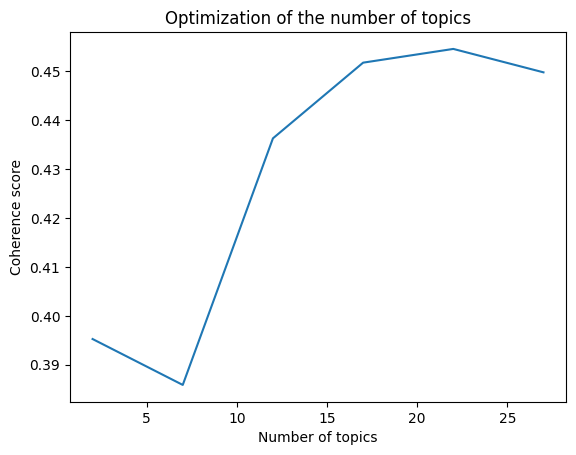

In [83]:
x = range(start, limit, step)
plt.plot(x, coherences_general)
plt.xlabel("Number of topics")
plt.ylabel("Coherence score")
plt.title("Optimization of the number of topics")
output_path = f"{output_directory}OptimisationGeneral2_25.png"
plt.savefig(output_path, bbox_inches='tight')
plt.show()

In [84]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=list(x), y=coherences_general, mode='lines', name='Coherence Score'))


fig.update_layout(
    paper_bgcolor='rgba(0,0,0,0)', 
    plot_bgcolor='rgba(0,0,0,0)',
    title="Optimization of the number of topics",
    xaxis_title="Number of topics",
    yaxis_title="Coherence score",
    xaxis=dict(showgrid=False),  
    yaxis=dict(showgrid=False) 
)
output_path = f"{output_directory}OptimisationGeneral2_25.html"
fig.write_html(output_path)


In [85]:
start = 2
limit = 6
step = 1
models_general, coherences_general = compute_coherence_values(dictionary=dictionary_general, corpus=corpus_general, texts=tokenized_documents_general, start=start, limit=limit, step=step)

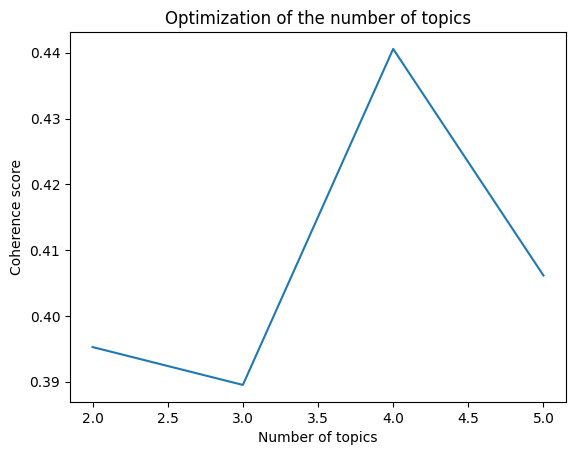

In [87]:
x = range(start, limit, step)

fig = go.Figure()

fig.add_trace(go.Scatter(x=list(x), y=coherences_general, mode='lines', name='Coherence Score'))


fig.update_layout(
    paper_bgcolor='rgba(0,0,0,0)', 
    plot_bgcolor='rgba(0,0,0,0)',
    title="Optimization of the number of topics",
    xaxis_title="Number of topics",
    yaxis_title="Coherence score",
    xaxis=dict(showgrid=False), 
    yaxis=dict(showgrid=False) 
)
output_path = f"{output_directory}OptimisationGeneral2_5.html"
fig.write_html(output_path)

output_path = f"{output_directory}OptimisationGeneral2_5.png"
plt.plot(x, coherences_general)
plt.xlabel("Number of topics")
plt.ylabel("Coherence score")
plt.title("Optimization of the number of topics")
plt.savefig(output_path)
plt.show()


In [88]:
# We take the model that gives the highest coherence
selected_coherences = np.max(coherences_general)
best_model_general= models_general[np.argmax(coherences_general)]

To understand the chosen model, we display its coherence score and, for each topic, we provide:

The top 10 words associated with the topic
The most representative movie, identified as the one with the highest score for that topic

In [89]:
top_themes_per_document = []
for i, doc in enumerate(corpus_general):
    doc_topics = best_model_general.get_document_topics(doc, minimum_probability=0)
    sorted_doc_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)
    
    top_indices = [topic_id for topic_id, _ in sorted_doc_topics[:3]]
    top_proportions = [proportion for _, proportion in sorted_doc_topics[:3]]

    top_themes_per_document.append({
        "Wikipedia movie ID": ids[i],
        "Theme 1": top_indices[0],
        "Prop Theme 1": top_proportions[0],
    })

df_top_themes = pd.DataFrame(top_themes_per_document)

df_date_clean['Wikipedia movie ID'] = df_date_clean['Wikipedia movie ID'].astype(str)
df_top_themes['Wikipedia movie ID'] = df_top_themes['Wikipedia movie ID'].astype(str)
merged_df = pd.merge(df_date_clean, df_top_themes, on='Wikipedia movie ID', how='inner')

best_movies_per_theme = merged_df.loc[merged_df.groupby("Theme 1")["Prop Theme 1"].idxmax()]
best_movies_per_theme.head()

print(f"\nCoherence of the selected model: {selected_coherences}\n")
for idx, topic in best_model_general.print_topics(-1):
    best_movie_data = best_movies_per_theme.loc[best_movies_per_theme['Theme 1'] == idx]
    movie_name = best_movie_data['Movie name'].values[0]
    proportion = best_movie_data['Prop Theme 1'].values[0]
    print(f"Topic {idx}: {topic}")
    print(f"Best representative movie: {movie_name} (Proportion: {proportion:.4f})\n")


Coherence of the selected model: 0.4405771276986953

Topic 0: 0.014*"father" + 0.013*"family" + 0.013*"love" + 0.010*"son" + 0.009*"child" + 0.009*"mother" + 0.008*"marry" + 0.007*"young" + 0.007*"daughter" + 0.007*"story"
Best representative movie: Henry VIII (Proportion: 0.9972)

Topic 1: 0.011*"friend" + 0.008*"love" + 0.007*"money" + 0.007*"home" + 0.006*"time" + 0.006*"father" + 0.006*"school" + 0.006*"mother" + 0.005*"woman" + 0.005*"return"
Best representative movie: Main Aur Mrs Khanna (Proportion: 0.9979)

Topic 2: 0.008*"police" + 0.008*"car" + 0.008*"house" + 0.006*"shoot" + 0.006*"room" + 0.005*"head" + 0.005*"escape" + 0.005*"murder" + 0.005*"body" + 0.005*"night"
Best representative movie: Film (Proportion: 0.9982)

Topic 3: 0.007*"escape" + 0.006*"attack" + 0.005*"ship" + 0.005*"return" + 0.005*"group" + 0.005*"order" + 0.005*"force" + 0.005*"destroy" + 0.005*"fight" + 0.004*"soldier"
Best representative movie: Stargate (Proportion: 0.9979)



Now, we want to plot the distribution of movie themes across the focus countries

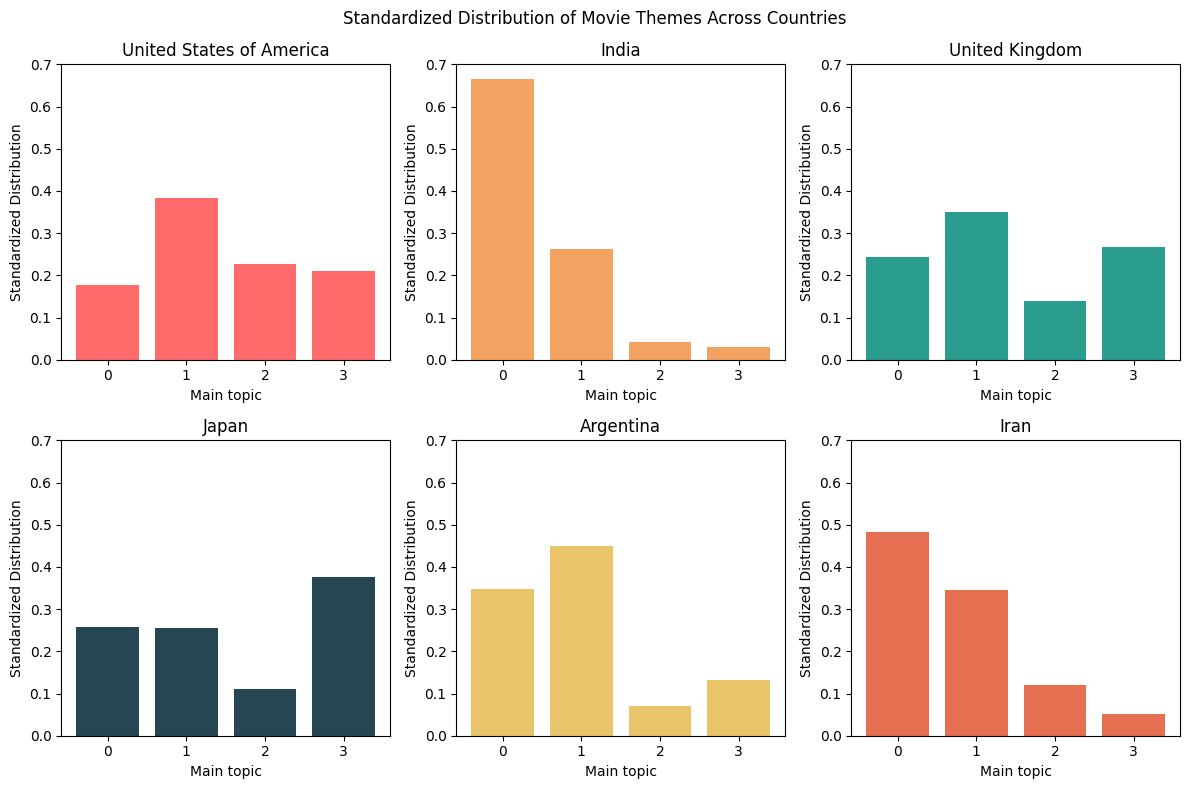

In [90]:
num_columns = 3
num_rows = 2
fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 8))
fig.suptitle('Standardized Distribution of Movie Themes Across Countries')
axes = axes.flatten()

for idx, country in enumerate(focus_countries):
    movies = merged_df[merged_df['Movie country'] == country]
    theme_counts = movies['Theme 1'].value_counts()
    theme_counts_stand = theme_counts / theme_counts.sum()

    axes[idx].bar(theme_counts_stand.index, theme_counts_stand.values,color=color_dict[country])
    axes[idx].set_title(f"{country}")
    axes[idx].set_xlabel("Main topic")
    axes[idx].set_ylabel("Standardized Distribution")
    axes[idx].set_xticks(theme_counts_stand.index)  # Ensure theme indices show up correctly on x-axis
    axes[idx].set_xticklabels(theme_counts_stand.index)

for ax in axes:
    ax.set_ylim(0, 0.7)

output_path = f"{output_directory}Standardized_Distribution_Movie.png"
plt.tight_layout()
plt.savefig(output_path)
plt.show()

In [112]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

num_columns = 3
num_rows = 2

fig = make_subplots(rows=num_rows, cols=num_columns,
                    subplot_titles=focus_countries, 
                    shared_xaxes=True, shared_yaxes=True)

for idx, country in enumerate(focus_countries):
    movies = merged_df[merged_df['Movie country'] == country]
    theme_counts = movies['Theme 1'].value_counts()
    theme_counts_stand = theme_counts / theme_counts.sum()

    row = idx // num_columns + 1
    col = idx % num_columns + 1

    fig.add_trace(go.Bar(
        x=theme_counts_stand.index, 
        y=theme_counts_stand.values, 
        name=country,
        marker_color=color_dict.get(country, 'rgba(0,0,0,0.8)')
    ), row=row, col=col)

    fig.update_xaxes(title_text="Main topic", tickmode='array', tickvals=theme_counts_stand.index, ticktext=theme_counts_stand.index, row=row, col=col)
    fig.update_yaxes(title_text="Standardized Distribution", range=[0, 0.7], row=row, col=col)

fig.update_layout(
    paper_bgcolor='rgba(0,0,0,0)', 
    plot_bgcolor='rgba(0,0,0,0)', 
    title_text="Standardized Distribution of Movie Themes Across Countries",
    showlegend=False,  
    height=800,
    width=1200,
    title_x=0.5,
)


output_path = f"{output_directory}/Standardized_Distribution_Movie.html"
fig.write_html(output_path)


In [92]:
import webbrowser


# Ouvrir le fichier HTML dans le navigateur par défaut
webbrowser.open(output_path)

True

## Genre specific LDA analysis 
We focus our LDA analysis on specific movie genres to explore whether notable thematic differences exist across countries. 

In [96]:
movie_genres=df_date_clean["Movie genres"].unique()
genre_documents = {genre: [] for genre in movie_genres}
ids_documents = {genre: [] for genre in movie_genres}
number_films_minimum = 1000 # treshold for the number of films

for i, doc in enumerate(documents):
    row = df_date_clean[df_date_clean['Wikipedia movie ID'].astype(int) == ids[i]]
    if not row.empty:
        genre = row['Movie genres'].iloc[0]
        genre_documents[genre].append(doc)
        ids_documents[genre].append(ids[i])
    else:
        # Skip if no matching row is found: this indicates that the plot belongs to a movie for which we lack corresponding data in df_date_clean.
        continue

In [97]:
# We consider only the genres with more than 1000 plots.
filter_genre_documents = {key: value for key, value in genre_documents.items() if len(value) > number_films_minimum}

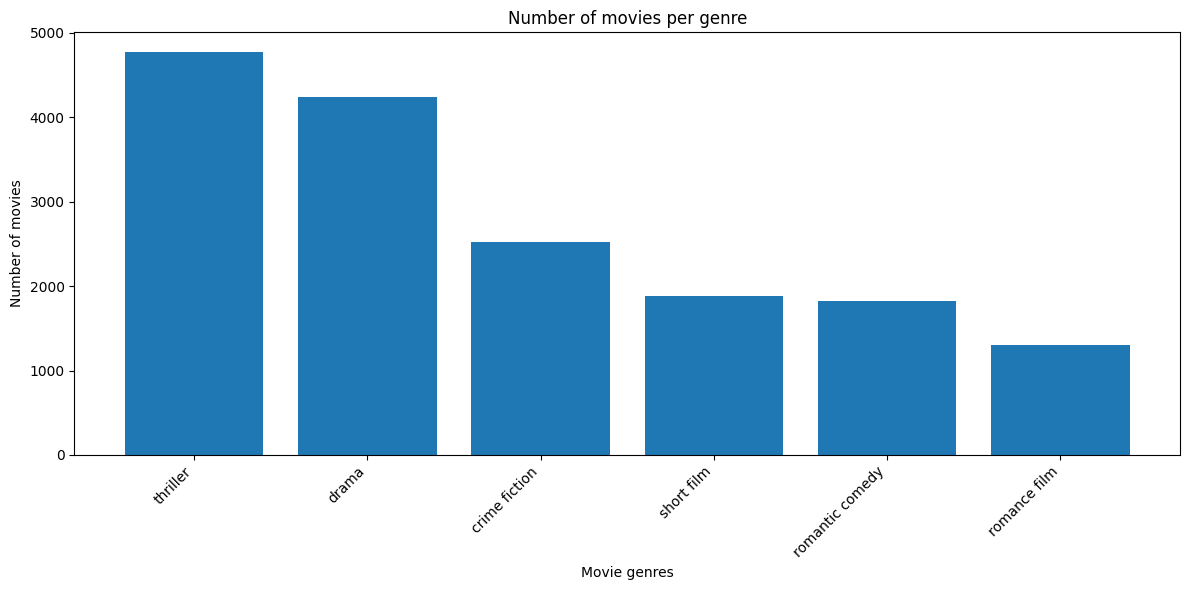

In [98]:
genre_counts = {genre: len(docs) for genre, docs in filter_genre_documents.items()}
genre_counts = dict(sorted(genre_counts.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(12, 6))
plt.bar(genre_counts.keys(), genre_counts.values())
plt.xlabel('Movie genres')
plt.ylabel('Number of movies')
plt.title('Number of movies per genre')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
output_path = f"{output_directory}Number_movies_per_genre.png"
plt.savefig(output_path)
plt.show()

In [99]:
fig = px.bar(x=list(genre_counts.keys()), y=list(genre_counts.values()),
             labels={'x': 'Movie genres', 'y': 'Number of movies'},
             title='Number of movies per genre')

fig.update_layout(
    xaxis_tickangle=45,
    xaxis_title='Movie genres',
    yaxis_title='Number of movies',
    xaxis=dict(showgrid=False),  
    yaxis=dict(showgrid=False) 
)

output_path = f"{output_directory}Number_movies_per_genre.html"
fig.write_html(output_path)


To focus on genres with substantial data, we treat ['romantic comedy', 'romance film'] as a single "romance" genre, as the topics in these two types of movies are not significantly different.

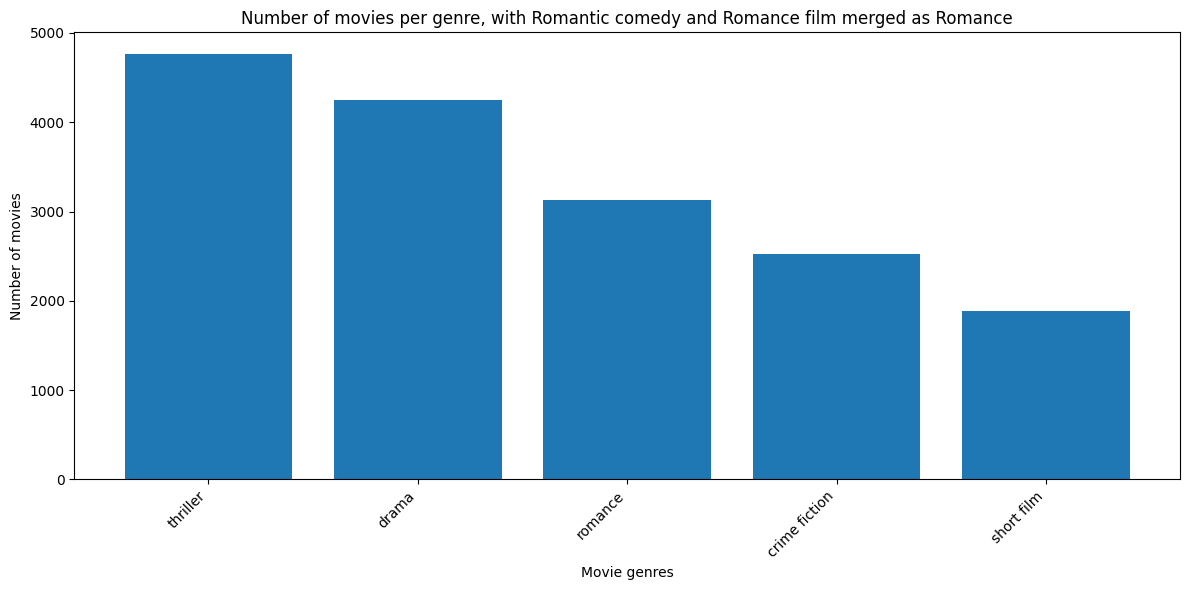

In [100]:
merged_genres = {}
merged_ids = {}
merged_genres['romance'] = []
merged_ids['romance'] = []

for genre, docs in filter_genre_documents.items():
    if genre in ['romantic comedy', 'romance film']:
        merged_genres['romance'].extend(docs)
        merged_ids['romance'].extend(ids_documents[genre])
    else:
        if genre not in merged_genres:
            merged_genres[genre] = []
            merged_ids[genre] = []
        merged_genres[genre].extend(docs)
        merged_ids[genre].extend(ids_documents[genre])


genre_counts2 = {genre: len(docs) for genre, docs in merged_genres.items()}
genre_counts2 = dict(sorted(genre_counts2.items(), key=lambda item: item[1], reverse=True))


plt.figure(figsize=(12, 6))
plt.bar(genre_counts2.keys(), genre_counts2.values())
plt.xlabel('Movie genres')
plt.ylabel('Number of movies')
plt.title('Number of movies per genre, with Romantic comedy and Romance film merged as Romance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
output_path = f"{output_directory}Number_movies_per_genre_romancemerge.png"
plt.savefig(output_path)
plt.show()

In [101]:
fig = px.bar(x=list(genre_counts2.keys()), y=list(genre_counts2.values()),
             labels={'x': 'Movie genres', 'y': 'Number of movies'},
             title='Number of movies per genre')

fig.update_layout(
    paper_bgcolor='rgba(0,0,0,0)', 
    plot_bgcolor='rgba(0,0,0,0)', 
    xaxis_tickangle=45,
    xaxis_title='Movie genres',
    yaxis_title='Number of movies',
    xaxis=dict(showgrid=False),  
    yaxis=dict(showgrid=False) 
)

output_path = f"{output_directory}Number_movies_per_genreromancemerge.html"
fig.write_html(output_path)


So we can study the topics in those top 3 genres: Thriller, Drama and Romance

In [102]:
top_3_genres = list(genre_counts2.keys())[:3]

top_3_genres_dict = {genre: merged_genres[genre] for genre in top_3_genres}
top_3_genres_ids = {genre: merged_ids[genre] for genre in top_3_genres}

In [103]:
# We create specific dictionnary and corpus per genres
genre_tokenized_documents = {genre: [] for genre in top_3_genres_dict}
genre_dictionary = {genre: [] for genre in top_3_genres_dict}
genre_corpus = {genre: [] for genre in top_3_genres_dict}

for genre in top_3_genres_dict:
    tokenized_documents = [[word for word in doc.lower().split() if len(word) >= 2] for doc in top_3_genres_dict[genre]]
    dictionary = Dictionary(tokenized_documents)
    dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)
    genre_tokenized_documents[genre] = tokenized_documents
    genre_dictionary[genre] = dictionary
    corpus = [dictionary.doc2bow(doc) for doc in tokenized_documents]
    genre_corpus[genre] = corpus

In [104]:
# Similar to the general case, but this time for each genre, we fine-tune the number of topics, limiting it to 6.
genre_models = {genre: [] for genre in top_3_genres_dict}
coherence_values = {genre: [] for genre in top_3_genres_dict}
for genre in top_3_genres_dict:
    genre_models[genre], coherence_values[genre] = compute_coherence_values(dictionary=genre_dictionary[genre], corpus=genre_corpus[genre], texts=genre_tokenized_documents[genre], start=start, limit=limit, step=step)

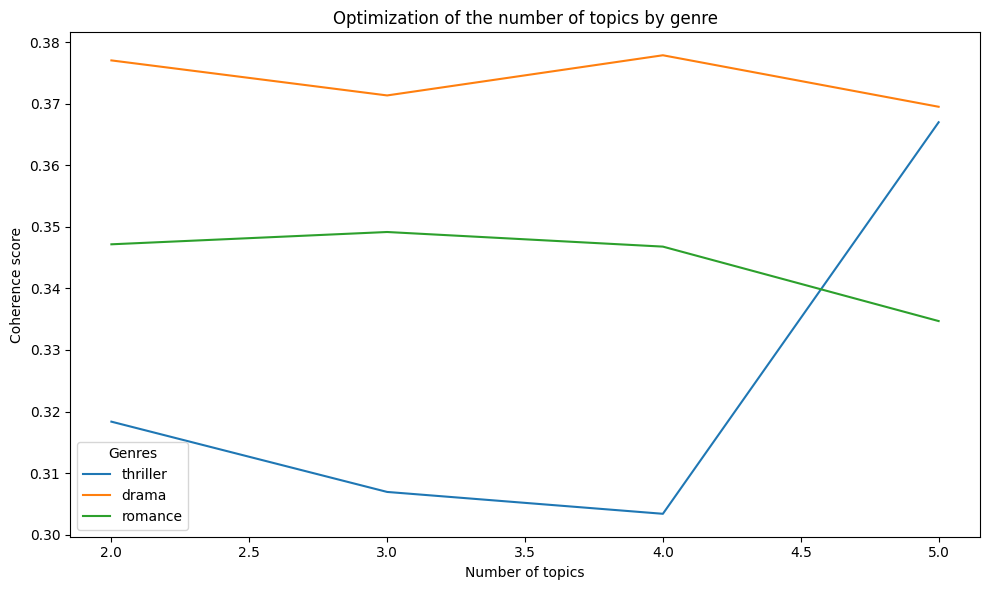

In [105]:
plt.figure(figsize=(10, 6))
for genre, values in coherence_values.items():
    plt.plot(x, values, label=genre)
    
plt.xlabel("Number of topics")
plt.ylabel("Coherence score")
plt.title("Optimization of the number of topics by genre")
plt.legend(title="Genres") 
plt.tight_layout()
output_path = f"{output_directory}OptimisationGenre.png"
plt.savefig(output_path)
plt.show()

In [106]:

fig = go.Figure()
x = list(x)
for genre, values in coherence_values.items():
    fig.add_trace(go.Scatter(x=x, y=values, mode='lines', name=genre))

fig.update_layout(
    paper_bgcolor='rgba(0,0,0,0)', 
    plot_bgcolor='rgba(0,0,0,0)', 
    title="Optimization of the number of topics by genre",
    xaxis_title="Number of topics",
    yaxis_title="Coherence score",
    legend_title="Genres",
    xaxis=dict(showgrid=False),  
    yaxis=dict(showgrid=False) 
)

output_path = f"{output_directory}OptimisationGenre.html"
fig.write_html(output_path)

In [107]:
# We select the models that give the highest coherence
selected_models = {}
selected_coherences = {}

for genre, models in genre_models.items():
    selected_coherences[genre] = np.max(coherence_values[genre])
    selected_models[genre] = models[np.argmax(coherence_values[genre])]


In [108]:
# Same display of the topics for each genre
top_themes_per_document_by_genre = {}

for genre in top_3_genres:
    top_theme = []
    top_proportion = []
    model = selected_models[genre]
    corpus = genre_corpus[genre]

    for i, doc in enumerate(corpus):
        doc_topics = model.get_document_topics(doc, minimum_probability=0)
        top_topic = max(doc_topics, key=lambda x: x[1])
        top_theme.append(top_topic[0])
        top_proportion.append(top_topic[1])

    genre_df = pd.DataFrame({
        "Wikipedia movie ID": merged_ids[genre],
        "Theme 1": top_theme,
        "Prop Theme 1": top_proportion,
    })

    df_date_clean['Wikipedia movie ID'] = df_date_clean['Wikipedia movie ID'].astype(int)
    genre_df['Wikipedia movie ID'] = genre_df['Wikipedia movie ID'].astype(int)
    genre_df = pd.merge(df_date_clean, genre_df, on="Wikipedia movie ID", how="inner")
    top_themes_per_document_by_genre[genre] = genre_df
    print(f'Genre:{genre}')
    print(f"Coherence of the selected model: {selected_coherences[genre]}\n")
    for idx, topic in model.print_topics(-1):
        best_movie_data = genre_df.loc[genre_df['Theme 1'] == idx]
        movie_name = best_movie_data['Movie name'].values[0]
        proportion = best_movie_data['Prop Theme 1'].values[0]
        print(f"Topic {idx}: {topic}")
        print(f"Best representative movie: {movie_name} (Proportion: {proportion:.4f})\n")
    print("\n\n")


Genre:thriller
Coherence of the selected model: 0.36697422701330573

Topic 0: 0.008*"attack" + 0.007*"car" + 0.007*"body" + 0.006*"house" + 0.006*"room" + 0.006*"group" + 0.005*"head" + 0.005*"attempt" + 0.005*"dead" + 0.004*"die"
Best representative movie: White Of The Eye (Proportion: 0.4554)

Topic 1: 0.007*"woman" + 0.006*"apartment" + 0.006*"killer" + 0.005*"case" + 0.005*"room" + 0.004*"wife" + 0.004*"house" + 0.004*"home" + 0.004*"night" + 0.004*"shoot"
Best representative movie: ...And Justice for All (Proportion: 0.8097)

Topic 2: 0.006*"order" + 0.005*"agent" + 0.005*"attempt" + 0.005*"attack" + 0.005*"force" + 0.004*"bomb" + 0.004*"group" + 0.004*"destroy" + 0.004*"team" + 0.004*"mission"
Best representative movie: Ghosts of Mars (Proportion: 0.6785)

Topic 3: 0.012*"shoot" + 0.011*"car" + 0.009*"money" + 0.008*"gang" + 0.008*"gun" + 0.006*"officer" + 0.005*"head" + 0.005*"drug" + 0.005*"steal" + 0.004*"attempt"
Best representative movie: Perrier's Bounty (Proportion: 0.9191

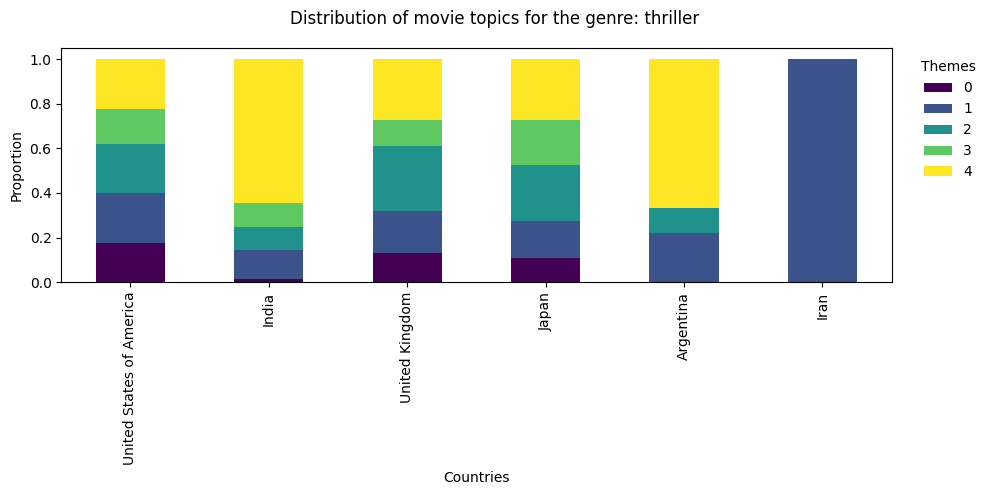

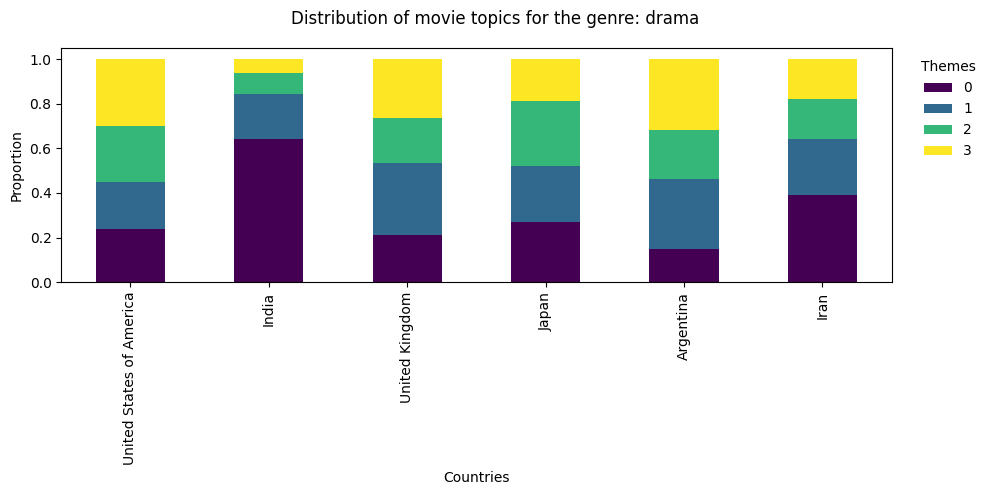

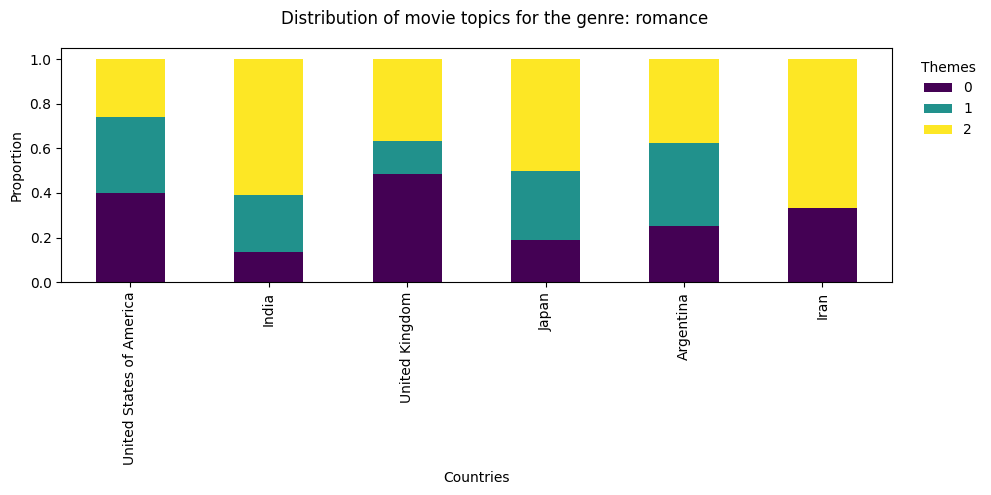

In [109]:
for idx, genre in enumerate(selected_models):
    # Créer une nouvelle figure
    fig, ax = plt.subplots(figsize=(10, 5))
    fig.suptitle(f'Distribution of movie topics for the genre: {genre}')

    # Données pour le genre courant
    merged_df = top_themes_per_document_by_genre[genre]
    theme_data = merged_df[['Movie country', 'Theme 1']]
    theme_counts = theme_data.groupby(['Movie country', 'Theme 1']).size().unstack(fill_value=0)
    theme_proportions = theme_counts.div(theme_counts.sum(axis=1), axis=0)

    # Graphique pour le genre courant
    theme_proportions.loc[focus_countries].plot(kind='bar', stacked=True, ax=ax, colormap='viridis')
    ax.set_xlabel("Countries")
    ax.set_ylabel("Proportion")
    ax.legend(title="Themes", bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)

    plt.tight_layout()
    output_path = f"{output_directory}{genre}_topic_distribution.png"
    fig.savefig(output_path, bbox_inches='tight')
    plt.show()

In [110]:

figures = []


for genre in selected_models:
    merged_df = top_themes_per_document_by_genre[genre]
    theme_data = merged_df[['Movie country', 'Theme 1']]
    theme_counts = theme_data.groupby(['Movie country', 'Theme 1']).size().unstack(fill_value=0)
    theme_proportions = theme_counts.div(theme_counts.sum(axis=1), axis=0) * 100  # Convert to percentage

    theme_proportions = theme_proportions.loc[focus_countries]

    theme_proportions.reset_index(inplace=True)
    melted_df = theme_proportions.melt(id_vars='Movie country', var_name='Theme', value_name='Percentage')

    fig = px.bar(
        melted_df,
        x='Movie country',
        y='Percentage',
        color='Theme',
        title=f'Standardized Distribution of Movie Themes: {genre}',
        text_auto='.2f',
    )

    fig.update_layout(
        paper_bgcolor='rgba(0,0,0,0)', 
        plot_bgcolor='rgba(0,0,0,0)', 
        xaxis_title="Countries",
        yaxis_title="Percentage (%)",
        legend_title="Themes",
        title_x=0.5,
        xaxis=dict(showgrid=False),  
        yaxis=dict(showgrid=False) 
    )
    output_path = f"{output_directory}{genre}_topic_distribution.html"
    fig.write_html(output_path)
    print(f"Plot saved for genre '{genre}' at: {output_path}")
    figures.append(fig)





Plot saved for genre 'thriller' at: docs/assets/graphs/thriller_topic_distribution.html
Plot saved for genre 'drama' at: docs/assets/graphs/drama_topic_distribution.html
Plot saved for genre 'romance' at: docs/assets/graphs/romance_topic_distribution.html


In [111]:
print(df_date_clean[df_date_clean["Movie name"]=="Film"])

       Wikipedia movie ID Freebase movie ID Movie name  Movie release date  \
51067              151807         /m/013rvb       Film                1965   

       Movie box office revenue  Movie runtime       Movie languages  \
51067                       NaN           24.0  ['English Language']   

                  Movie country Movie genres  
51067  United States of America   short film  
